# Analyzing Data for wiu global-probe to cf worker

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

## Import data set

In [2]:
# udpate for file import
timestamp = '2023-11-04-16-09' 
size = 100

# load data into pandas dataframe
file_name = 'data/{time}-s{size}.csv'.format(time=timestamp, size=str(size))
df = pd.read_csv(file_name)
df.head()

,responseCode,responseStatus,contentLength,serverIP,timingConnected,timingResponse,timingRequest,timingTransfer,location,latitude,longitude
0,200,OK,102400,104.21.71.190,0.107230,0.353166,0.353659,0.503092,accra,5.6037,-0.1870
1,200,OK,102400,104.21.71.190,0.051157,0.409662,0.409859,0.421360,adelaide,-34.9333,138.5833
2,200,OK,102400,104.21.71.190,0.004762,0.244138,0.244527,0.252348,albany,42.7469,-73.7589
3,200,OK,102400,172.67.148.21,0.003164,1.070145,1.070385,1.075531,alblasserdam,51.8667,4.6500
4,200,OK,102400,104.21.71.190,0.021528,0.233266,0.233639,0.452024,albuquerque,35.1107,-106.6100


## Normalize Data & Cleaning

In [3]:
# map location -> int (histogram)
location_to_int_mapping = {location: idx for idx, location in enumerate(df['location'].unique())}
df['location_int'] = df['location'].map(location_to_int_mapping)

# timing in ms
timing_to_ms_mapping = {timing: timing * 100 for _, timing in enumerate(df['timingConnected'])}
df['connected_time_ms'] = df['timingConnected'].map(timing_to_ms_mapping)

timing_to_ms_mapping = {timing: timing * 100 for _, timing in enumerate(df['timingResponse'])}
df['response_time_ms'] = df['timingResponse'].map(timing_to_ms_mapping)

timing_to_ms_mapping = {timing: timing * 100 for _, timing in enumerate(df['timingRequest'])}
df['request_time_ms'] = df['timingRequest'].map(timing_to_ms_mapping)

timing_to_ms_mapping = {timing: timing * 100 for _, timing in enumerate(df['timingTransfer'])}
df['transfer_time_ms'] = df['timingTransfer'].map(timing_to_ms_mapping)


df.head()

,responseCode,responseStatus,contentLength,serverIP,timingConnected,timingResponse,timingRequest,timingTransfer,location,latitude,longitude,location_int,connected_time_ms,response_time_ms,request_time_ms,transfer_time_ms
0,200,OK,102400,104.21.71.190,0.107230,0.353166,0.353659,0.503092,accra,5.6037,-0.1870,0,10.7230,35.3166,35.3659,50.3092
1,200,OK,102400,104.21.71.190,0.051157,0.409662,0.409859,0.421360,adelaide,-34.9333,138.5833,1,5.1157,40.9662,40.9859,42.1360
2,200,OK,102400,104.21.71.190,0.004762,0.244138,0.244527,0.252348,albany,42.7469,-73.7589,2,0.4762,24.4138,24.4527,25.2348
3,200,OK,102400,172.67.148.21,0.003164,1.070145,1.070385,1.075531,alblasserdam,51.8667,4.6500,3,0.3164,107.0145,107.0385,107.5531
4,200,OK,102400,104.21.71.190,0.021528,0.233266,0.233639,0.452024,albuquerque,35.1107,-106.6100,4,2.1528,23.3266,23.3639,45.2024


## Plot graphs
### 1.1 connected time VS location

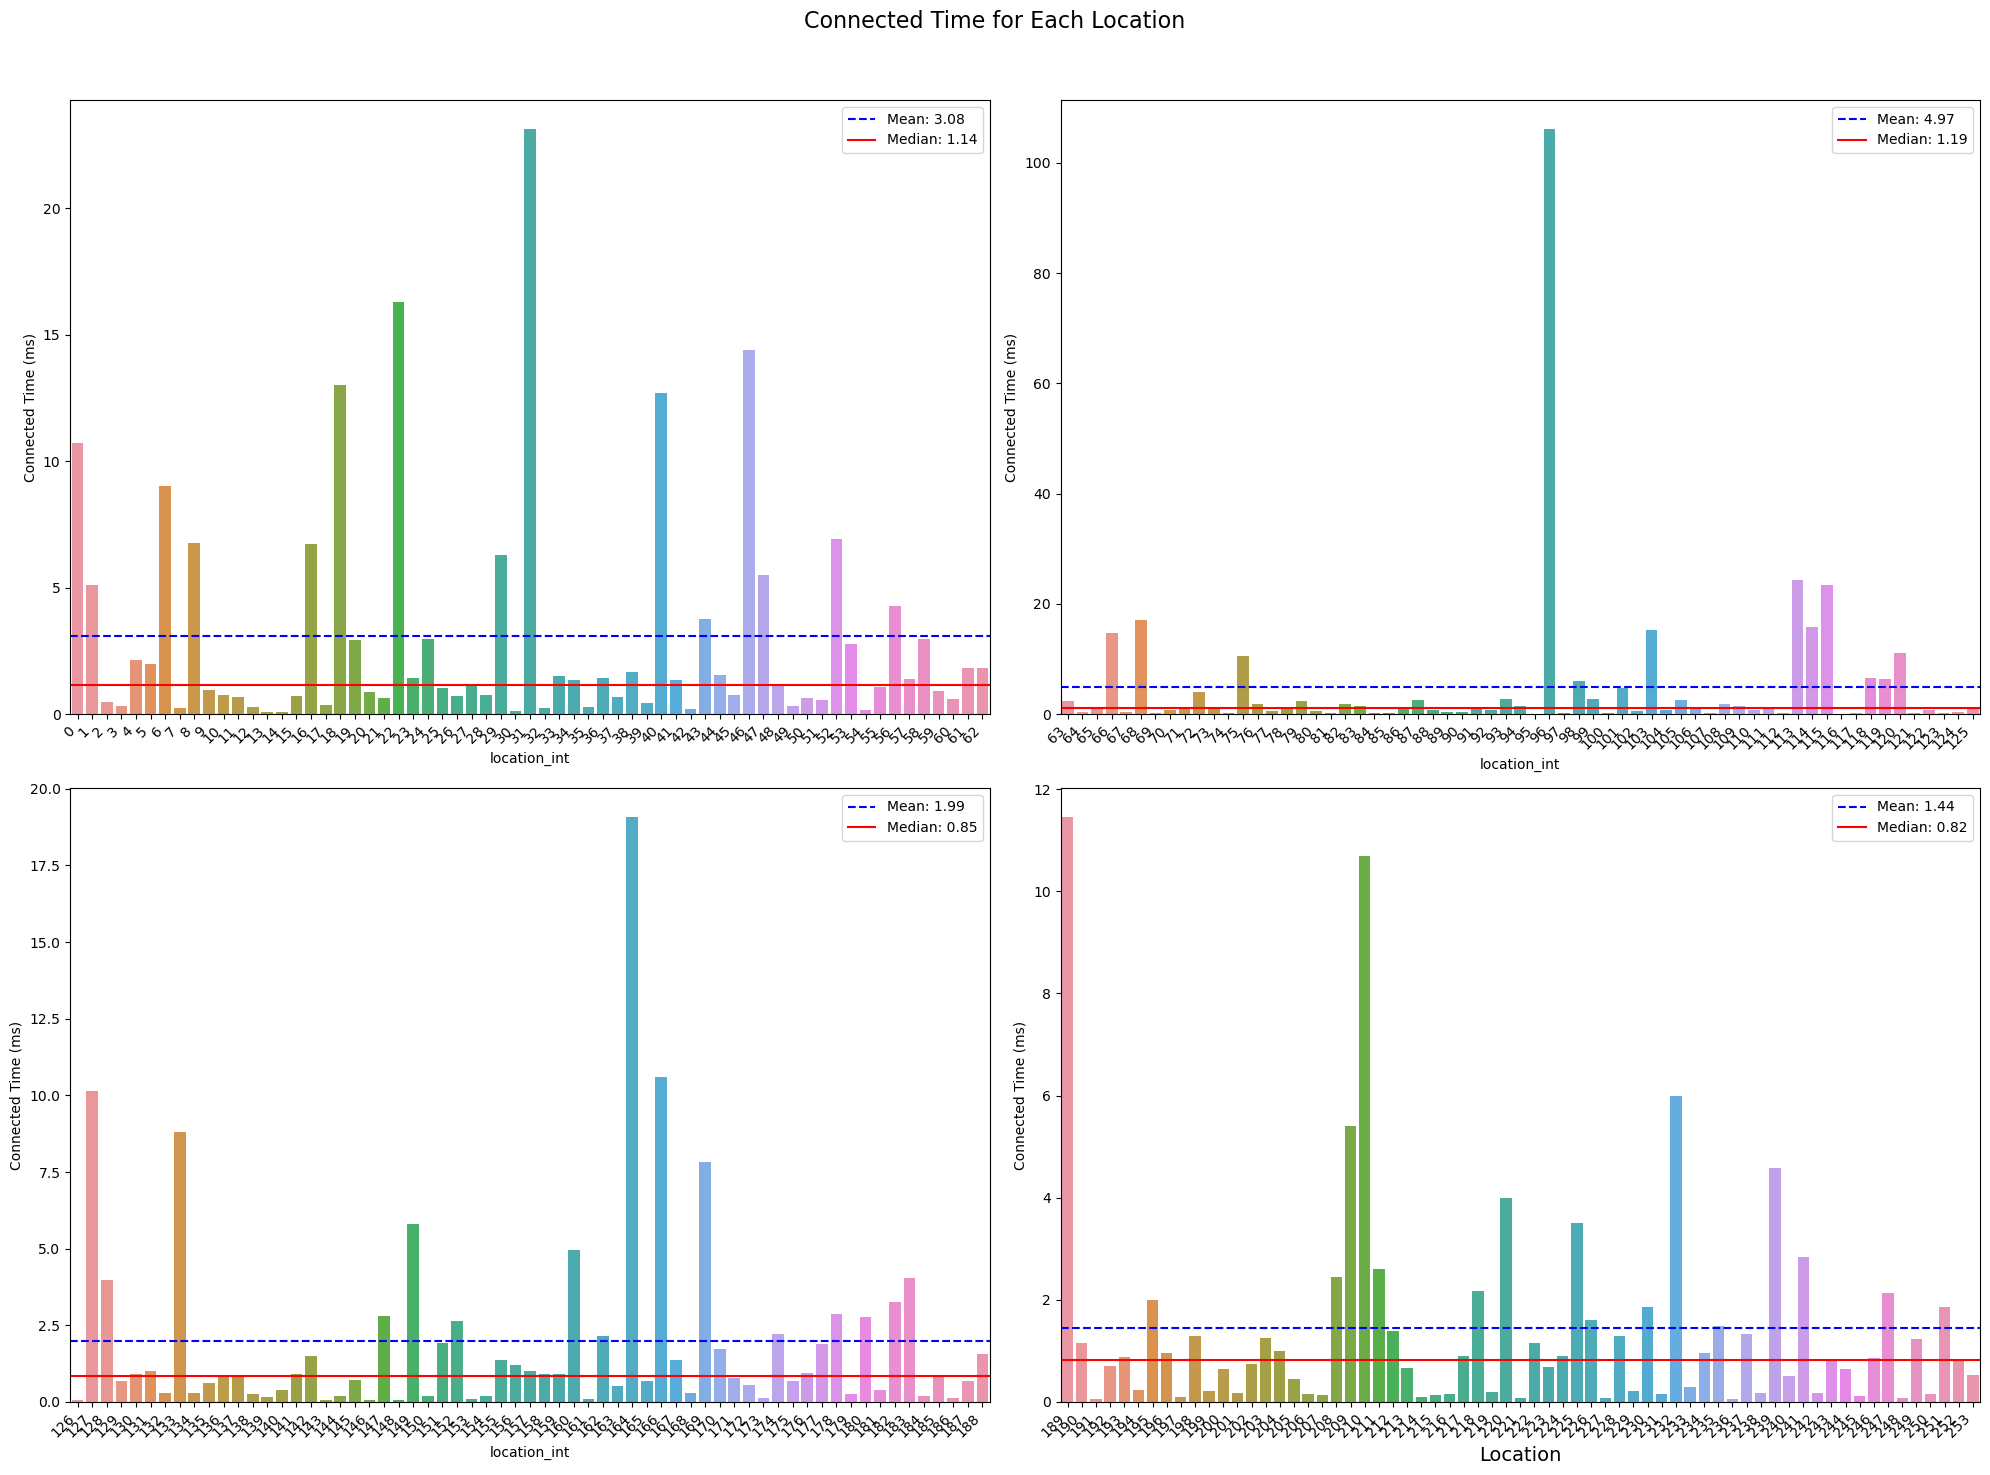

In [4]:
# Number of locations per subplot
num_locations = len(df) // 4

# Create a larger figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))  # adjust the size as needed
axs = axs.flatten()  # Flatten the 2x2 grid into a single list for easier indexing

for i in range(4):
    # Calculate the start and end indices for the data slice
    start_idx = i * num_locations
    end_idx = (i + 1) * num_locations if i != 3 else None  # go to the end for the last slice
    # Select the data slice
    df_slice = df.iloc[start_idx:end_idx]
    # Create the bar plot for this slice
    sns.barplot(data=df_slice, x='location_int', y='connected_time_ms', ax=axs[i])
    # Calculate mean and median
    mean_val = df_slice['connected_time_ms'].mean()
    median_val = df_slice['connected_time_ms'].median()
    # Add lines for mean and median
    axs[i].axhline(mean_val, color='blue', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axs[i].axhline(median_val, color='red', linestyle='-', label=f'Median: {median_val:.2f}')
    
    # Set the legend
    axs[i].legend()

    # Rotate the x-axis labels for readability
    for label in axs[i].get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

    # Set the y-axis label
    axs[i].set_ylabel('Connected Time (ms)')

# Set the overall title and labels
fig.suptitle('Connected Time for Each Location', fontsize=16)
plt.xlabel('Location', fontsize=14)  # This sets label only for the last subplot

# Adjust layout and make sure the plots do not overlap
plt.tight_layout()
# Remember the overall title space
plt.subplots_adjust(top=0.92)

# Show the plot
plt.show()

### 1.2 Import packagefor geographic

In [7]:
import folium
from branca.colormap import linear

In [9]:
# Create a map object
world_map = folium.Map(location=[20, 0], zoom_start=2)  # Adjusted for a better initial view

# Normalize the timingConnected for color coding
max_value = df['timingConnected'].max()
min_value = df['timingConnected'].min()
colormap = linear.YlOrRd_09.scale(min_value, max_value)

# Add markers to the map
for _, row in df.iterrows():
    color = colormap(row['timingConnected'])
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=(folium.Popup(f"Location: {row['location']}<br>"
                            f"timingConnected: {row['timingConnected']:.5f}", max_width=300))
    ).add_to(world_map)

# Add the color scale to the map
colormap.caption = "Connection Timing (seconds)"
world_map.add_child(colormap)

# Display the map
world_map